### For splitting the microsoft buildings layer into county level shapefiles!

OG data can be found here: https://github.com/microsoft/USBuildingFootprints

In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

In [3]:
os.chdir('C:\\Users\\phwh9568\\Data')

Import the buildings layer: 

(this may take a while)

In [4]:
buildings = gpd.read_file('Colorado_Microsoft_Footprints\\Colorado.geojson')

In [5]:
len(buildings)

2080808

In [6]:
buildings.columns

Index(['geometry'], dtype='object')

Import the US counties tigerline file:

In [7]:
countyUS = gpd.read_file('tl_2019_us_county\\tl_2019_us_county.shp')

Check the CRS of the county layer:

In [8]:
countyUS.crs

{'init': 'epsg:4269'}

Reset the county layer's CRS to WGS84 (same as buildings layer)

In [9]:
countyUS = countyUS.to_crs({'init': 'epsg:4326'})

In [10]:
countyUS.crs

{'init': 'epsg:4326'}

Isolate Colorado counties:

In [11]:
Colorado_Counties = countyUS.loc[countyUS['STATEFP'] == '08']

Drop unnecessary fields:

In [12]:
Colorado_Counties = Colorado_Counties[['NAMELSAD', 'geometry']]

In [13]:
Colorado_Counties

,NAMELSAD,geometry
22,Saguache County,"POLYGON ((-106.87140 37.94189, -106.87199 37.9..."
106,Sedgwick County,"POLYGON ((-102.65211 40.88463, -102.65211 40.8..."
123,Cheyenne County,"POLYGON ((-102.57685 39.04068, -102.56133 39.0..."
162,Custer County,"POLYGON ((-105.79690 38.26505, -105.78341 38.2..."
199,La Plata County,"POLYGON ((-108.29516 37.21501, -108.29460 37.2..."
...,...,...
2947,Mesa County,"POLYGON ((-109.05148 39.11650, -109.05147 39.1..."
2992,Dolores County,"POLYGON ((-108.82052 37.88085, -108.82050 37.8..."
2998,Arapahoe County,"MULTIPOLYGON (((-104.79137 39.56609, -104.7928..."
3151,Las Animas County,"POLYGON ((-105.02459 37.34849, -105.02459 37.3..."


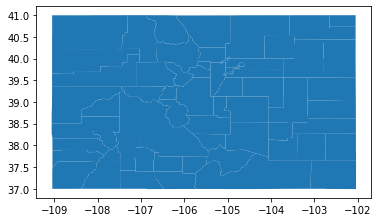

In [9]:
Colorado_Counties.plot()

### Time to spatial join county attributes to the buildings. 

*this worked* use 'within' instead of 'intersect'. 'intersect' is *very slow*. However, within doesn't get buildings that cross a county line, so afterward we'll isolate nulls (aka buildings that did not fall "within", and run an intersect sjoin on just those with the counties, then addend (pd.concat) them back to the individual county layers.

In [92]:
CO_footprints = gpd.sjoin(buildings, Colorado_Counties, how='left', op='within')

In [93]:
len(CO_footprints)

2080808

In [94]:
CO_footprints.isna().sum()

geometry         0
index_right    384
NAMELSAD       384
dtype: int64

In [95]:
CO_footprints.reset_index(inplace=True)

Drop index_right column as that will mess things up later

In [96]:
CO_footprints = CO_footprints.drop(['index_right'], axis = 1)

Isolate the nulls:

In [97]:
nulls = CO_footprints[CO_footprints.isna().any(axis=1)]

__In case you want to look at the nulls:__

In [17]:
nulls.to_file('Colorado_Microsoft_Footprints\\nulls.geojson', driver='GeoJSON')

Drop the 'NAMELSAD' column as this is filled with NaNs anyway and we will be adding it back via intersect

In [98]:
nulls = nulls.drop(['NAMELSAD'], axis = 1)

Spatial join the county attributes to the null values using intersect this time:

In [99]:
nulls = gpd.sjoin(nulls, Colorado_Counties, how='left', op='intersects')

Drop index right:

In [100]:
nulls = nulls.drop(['index_right'], axis = 1)

Create a county names list:

In [101]:
countyList = list(Colorado_Counties['NAMELSAD'])

### Time to split by county 

Using names in the county names list, create a variable of all of the buildings within a county, then repeat for that county in the (formerly) nulls list. Then use pd.concat to addend the formerly null buildings joined by 'intersect' to the earlier buildings joind by 'within'.

Create a file name by replacing spaces in the county name with an underscore, and add "buildings" to the name

Finally, write them all to a shapefile. They will appear in individual folders.

In [104]:
for name in countyList:
    countyFootPrints = CO_footprints.loc[CO_footprints['NAMELSAD'] == name]
    countyIntersects = nulls.loc[nulls['NAMELSAD'] == name]
    countyFootPrints = pd.concat([countyFootPrints, countyIntersects], ignore_index=True)
    countyFootPrints.rename(columns={'NAMELSAD':'County', 'index': 'FID'}, inplace = True)
    fileName = name.replace(" ","_")+'_Buildings'
    countyFootPrints.to_file('Colorado_Microsoft_Footprints\\'+fileName)

### [END]

Just some tests I was running to get this working smoothly:

In [133]:
countyName = 'El Paso County'

In [139]:
print (countyName.replace(" ","_"))

El_Paso_County


In [81]:
Denver_buildings = CO_footprints.loc[CO_footprints['NAMELSAD'] == 'Denver County']

In [82]:
Denver_buildings

,index,geometry,NAMELSAD
5579,5579,"POLYGON ((-105.05600 39.78397, -105.05586 39.7...",Denver County
5580,5580,"POLYGON ((-105.05480 39.78793, -105.05476 39.7...",Denver County
5581,5581,"POLYGON ((-105.05890 39.79022, -105.05886 39.7...",Denver County
5593,5593,"POLYGON ((-105.05192 39.77732, -105.05192 39.7...",Denver County
5594,5594,"POLYGON ((-105.04097 39.78433, -105.04090 39.7...",Denver County
...,...,...,...
2071207,2071207,"POLYGON ((-104.74482 39.77194, -104.74483 39.7...",Denver County
2071208,2071208,"POLYGON ((-104.74968 39.77243, -104.74985 39.7...",Denver County
2071209,2071209,"POLYGON ((-104.73803 39.76968, -104.73817 39.7...",Denver County
2071210,2071210,"POLYGON ((-104.73801 39.77027, -104.73801 39.7...",Denver County


In [83]:
Denver_nulls = nulls.loc[nulls['NAMELSAD']=='Denver County']

In [84]:
Denver_nulls

,index,geometry,NAMELSAD
7926,7926,"POLYGON ((-104.79749 39.77345, -104.79777 39.7...",Denver County
8185,8185,"POLYGON ((-104.92223 39.66578, -104.92204 39.6...",Denver County
8269,8269,"POLYGON ((-104.89107 39.66743, -104.89082 39.6...",Denver County
45406,45406,"POLYGON ((-105.03057 39.79184, -105.03057 39.7...",Denver County
48283,48283,"POLYGON ((-104.84837 39.65862, -104.84817 39.6...",Denver County
...,...,...,...
2029280,2029280,"POLYGON ((-105.06456 39.61458, -105.06456 39.6...",Denver County
2048648,2048648,"POLYGON ((-104.93947 39.69817, -104.93905 39.6...",Denver County
2048783,2048783,"POLYGON ((-104.93406 39.67122, -104.93406 39.6...",Denver County
2049631,2049631,"POLYGON ((-105.03457 39.63364, -105.03457 39.6...",Denver County


In [85]:
Denver_buildings = pd.concat([Denver_buildings,Denver_nulls], ignore_index=True)

In [86]:
len(Denver_buildings)

175603

In [88]:
Denver_buildings

,index,geometry,NAMELSAD
0,5579,"POLYGON ((-105.05600 39.78397, -105.05586 39.7...",Denver County
1,5580,"POLYGON ((-105.05480 39.78793, -105.05476 39.7...",Denver County
2,5581,"POLYGON ((-105.05890 39.79022, -105.05886 39.7...",Denver County
3,5593,"POLYGON ((-105.05192 39.77732, -105.05192 39.7...",Denver County
4,5594,"POLYGON ((-105.04097 39.78433, -105.04090 39.7...",Denver County
...,...,...,...
175598,2029280,"POLYGON ((-105.06456 39.61458, -105.06456 39.6...",Denver County
175599,2048648,"POLYGON ((-104.93947 39.69817, -104.93905 39.6...",Denver County
175600,2048783,"POLYGON ((-104.93406 39.67122, -104.93406 39.6...",Denver County
175601,2049631,"POLYGON ((-105.03457 39.63364, -105.03457 39.6...",Denver County


In [90]:
Denver_buildings.rename(columns={'NAMELSAD':'County', 'index': 'FID'}, inplace = True)

In [91]:
Denver_buildings

,FID,geometry,County
0,5579,"POLYGON ((-105.05600 39.78397, -105.05586 39.7...",Denver County
1,5580,"POLYGON ((-105.05480 39.78793, -105.05476 39.7...",Denver County
2,5581,"POLYGON ((-105.05890 39.79022, -105.05886 39.7...",Denver County
3,5593,"POLYGON ((-105.05192 39.77732, -105.05192 39.7...",Denver County
4,5594,"POLYGON ((-105.04097 39.78433, -105.04090 39.7...",Denver County
...,...,...,...
175598,2029280,"POLYGON ((-105.06456 39.61458, -105.06456 39.6...",Denver County
175599,2048648,"POLYGON ((-104.93947 39.69817, -104.93905 39.6...",Denver County
175600,2048783,"POLYGON ((-104.93406 39.67122, -104.93406 39.6...",Denver County
175601,2049631,"POLYGON ((-105.03457 39.63364, -105.03457 39.6...",Denver County


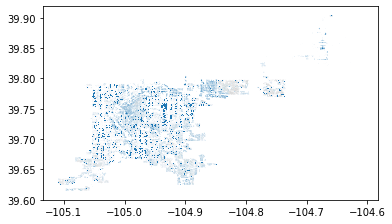

In [126]:
Denver_buildings.plot()

In [19]:
Boulder_buildings = CO_footprints.loc[CO_footprints['NAMELSAD'] == 'Boulder County']

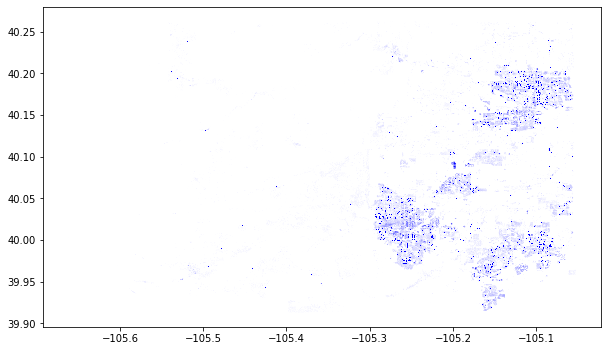

In [20]:
Boulder_buildings.plot(color='blue', figsize=(10,10))